In [1]:
# Load library
library(dplyr)
library(tidyverse)
library(weights)
tick_size  =  1.5
label_size = 2



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: gdata
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’




**Table of Contents**

1. [Abstract](#Analysis-in-Abstract)
1. [Strain deconvolution in the presence of relatedness](#Strain-deconvolution-in-the-presence-of-relatedness)
1. [IBD](#IBD)
1. [Prevalence](#Prevalence)

# Analysis in Abstract

In [4]:
pf3k_mixedIBD_meta = read_tsv("pf3k_mixedIBD_meta.txt")
head(pf3k_mixedIBD_meta[1:7])
dim(pf3k_mixedIBD_meta)

Parsed with column specification:
cols(
  ID = col_character(),
  Population = col_character(),
  Site = col_character(),
  Depth = col_double(),
  Est_K = col_integer(),
  P1 = col_double(),
  P2 = col_double(),
  P3 = col_double(),
  P4 = col_double(),
  group = col_character(),
  relatedness = col_double(),
  mean_IBD_length.kb = col_double(),
  N50_IBD_Length.kb = col_double(),
  Mean_IBD_goodness = col_double(),
  cluster = col_character(),
  year = col_integer(),
  eff_k = col_double()
)


ID,Population,Site,Depth,Est_K,P1,P2
PD0498-C,Thailand,Sisakhet,41.71,1,1.00,0.00
PD0499-C,Thailand,Sisakhet,195.66,3,0.00,0.15
PD0500-C,Thailand,Sisakhet,124.33,1,1.00,0.00
PD0501-C,Thailand,Sisakhet,114.03,1,0.99,0.00
PD0502-C,Thailand,Sisakhet,83.60,1,1.00,0.00
PD0575-C,Thailand,Sisakhet,151.78,1,1.00,0.00


[1] 2344   17

Rates of mixed infection vary from 18%-63% across countries

In [5]:
groupByCountry = group_by(pf3k_mixedIBD_meta, Population)
summarise(groupByCountry, sum(Est_K>1)/length(Est_K))[,2] %>% 
    range %>% cat("range",., "\n")


range 0.1824818 0.6301887 


In [6]:
#pfpr = read_tsv("pfpr_rate_inferred.txt")
pfpr = read_csv("global_mapPfPR_25mi.csv")
head(filter(pfpr, year > 2007))


Parsed with column specification:
cols(
  name = col_character(),
  continent = col_character(),
  country = col_character(),
  site = col_character(),
  year = col_integer(),
  closest = col_double(),
  mean_25 = col_double()
)


name,continent,country,site,year,closest,mean_25
"Bangladesh, Ramu, 2012",Asia,Bangladesh,Ramu,2012,0.002145085,0.001787199
"Cambodia, Pailin, 2011",Asia,Cambodia,Pailin,2011,0.002549504,0.011030702
"Cambodia, Pailin, 2012",Asia,Cambodia,Pailin,2012,0.000963063,0.006477311
"Cambodia, Preah_Vihear, 2011",Asia,Cambodia,Preah_Vihear,2011,0.016733585,0.012861789
"Cambodia, Preah_Vihear, 2012",Asia,Cambodia,Preah_Vihear,2012,0.007535842,0.007862510
"Cambodia, Pursat, 2009",Asia,Cambodia,Pursat,2009,0.007072821,0.016699761


In [28]:
mean_eff_k = c()
mean_relatedness = c()
sd_relatedness = c()
n.sample = c()


for ( i in 1:dim(pfpr)[1] ){
    country = pfpr$country[i]# label[i] %>% gsub(".2.*$","",.) %>% gsub(".1.*$","",.)
    site =  gsub("_", " ", pfpr$site[i])
    if (site == "GM Coastal"){site = "GM_Coastal"}
    if (country=="The_Gambia"){country ="The Gambia"}
    if (country=="DR_of_the_Congo"){country ="DR of the Congo"}
    year = pfpr$year[i]
    cat(country, site, year, "\n")
    tmpdata = pf3k_mixedIBD_meta[pf3k_mixedIBD_meta$Site == site & pf3k_mixedIBD_meta$year == year,]
#    print(head(tmpdata))
    mean_eff_k = c(mean_eff_k,  mean(tmpdata$eff_k))
    mean_relatedness = c(mean_relatedness, mean(tmpdata$relatedness, na.rm = T))
    sd_relatedness = c(sd_relatedness, sd(tmpdata$relatedness, na.rm = T)/sqrt(nrow(tmpdata)))
    n.sample = c(n.sample, nrow(tmpdata))
    cat(site, "", year, "", pfpr$closest[i], mean_eff_k, "", mean_relatedness, "\n")
}
mean_eff_k

Bangladesh Ramu 2012 
Ramu  2012  0.002145085 1.506594  0.494935 
Cambodia Pailin 2011 
Pailin  2011  0.002549504 1.506594 1.083161  0.494935 0.4343079 
Cambodia Pailin 2012 
Pailin  2012  0.000963063 1.506594 1.083161 1.038514  0.494935 0.4343079 0.4349629 
Cambodia Preah Vihear 2011 
Preah Vihear  2011  0.01673358 1.506594 1.083161 1.038514 1.229793  0.494935 0.4343079 0.4349629 0.3624064 
Cambodia Preah Vihear 2012 
Preah Vihear  2012  0.007535842 1.506594 1.083161 1.038514 1.229793 1.037526  0.494935 0.4343079 0.4349629 0.3624064 0.3753107 
Cambodia Pursat 2009 
Pursat  2009  0.007072821 1.506594 1.083161 1.038514 1.229793 1.037526 1.298419  0.494935 0.4343079 0.4349629 0.3624064 0.3753107 0.3867335 
Cambodia Pursat 2010 
Pursat  2010  0.007148045 1.506594 1.083161 1.038514 1.229793 1.037526 1.298419 1.234919  0.494935 0.4343079 0.4349629 0.3624064 0.3753107 0.3867335 0.6452868 
Cambodia Pursat 2011 
Pursat  2011  0.009576347 1.506594 1.083161 1.038514 1.229793 1.037526 1.298419 1.

[1] 1.506594 1.083161 1.038514 1.229793 1.037526 1.298419 1.234919 1.226180
 [9] 1.397328 1.332723 1.410362 1.330202 1.508799 1.586850 1.514260 1.526830
[17] 1.574883 1.573742 1.502049 1.565575 1.052486 1.426126 1.377482 1.283468
[25] 1.736456      NaN      NaN 1.649527      NaN 1.818195 1.346229 1.603496
[33] 1.194681 1.169375      NaN 1.000000 1.406531 1.010152 1.005537 1.126747
[41] 1.259363 1.064219 1.000000 1.000000 1.184474 1.256481 1.002256 1.154589
[49] 1.286570 1.128447 1.241379 1.285051 1.284053 1.128080 1.209773 1.178712

51% of mixed infections involve more than two strain

In [29]:
sum(pf3k_mixedIBD_meta$Est_K>2) / 
    sum(pf3k_mixedIBD_meta$Est_K>1)

[1] 0.5097038

47% of mixed infections are sibs

In [30]:
sum(pf3k_mixedIBD_meta$cluster %in% c("Sib", "HighSib")) / 
    sum(pf3k_mixedIBD_meta$Est_K>1)

[1] 0.4698672

### Correlation of mixed infection with prevalence

Weighted correlation between effecitve k and mean pfpr

In [32]:
cor.test(mean_eff_k, pfpr[["closest"]])


	Pearson's product-moment correlation

data:  mean_eff_k and pfpr[["closest"]]
t = 5.192, df = 50, p-value = 3.818e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3803852 0.7444996
sample estimates:
      cor 
0.5918474 


Weighted correlation between relatedness and mean pfpr

In [34]:
cor.test(mean_relatedness, pfpr[["closest"]])


	Pearson's product-moment correlation

data:  mean_relatedness and pfpr[["closest"]]
t = -3.1377, df = 44, p-value = 0.003036
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6386243 -0.1567604
sample estimates:
       cor 
-0.4275996 


# Strain deconvolution in the presence of relatedness

Rates of genotype error are also similar for the two approaches in settings of low relatedness (error rate of 0.4\% per site for 25/75 mixtures and 1.0\% for 45/55 mixtures).  However, for the 25/75 mixtures with high relatedness, genotype error for the non-IBD approach increases to 0.6\%, while error in the IBD approach remains at 0.4\%.  

In [35]:
simulation_error = read.table("simulation_error.txt", header=T)
all.nonIBD.error = simulation_error %>% filter(., method == "nonIBD")
all.IBD.error = simulation_error %>% filter(., method == "IBD")

In [36]:
group_by(all.IBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first25", case_panel))



case_panel,mean(genotypError)
first25percentSame.25v75,0.004110415
first25percentSame.45v55,0.010239353


In [37]:
group_by(all.nonIBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first75percentSame.25v75", case_panel))
group_by(all.IBD.error, case_panel) %>% 
    summarise(., mean(genotypError)) %>% 
    filter(., grepl("first75percentSame.25v75", case_panel))


case_panel,mean(genotypError)
first75percentSame.25v75,0.005814257


case_panel,mean(genotypError)
first75percentSame.25v75,0.00384954


In [38]:
plot_error_histogram <- function(error.data){
par(mfrow = c(3,2))

for (case in paste("first", c(25,50, 75), "percentSame", sep ="")){

    spacing = 7
    for (panel in c("25v75", "45v55")){
        tmp.case.panel = paste(case, ".", panel, sep ="")
        tmp.data = filter(error.data, case_panel == tmp.case.panel)
        if ( panel == "25v75" ){
            hist(tmp.data$swithError, breaks=seq(0, 71, by = spacing), 
                col = rgb(1,0,0,0.5), xlim = c(0,71), ylim=c(0, 70), 
                 main = case, xlab = paste("Number of switches"), 
                 cex = 2, cex.lab = 2, cex.axis = 1.4)
        } else {
            hist(tmp.data$swithError, breaks=seq(0, 71, by = spacing), 
                 add = T, col = rgb(0,0,1,0.5))
        }
    }
    legend("topright", c("Mixing of 25/75%", "Mixing of 45/55%"), 
           fill=c(rgb(1,0,0,0.5), rgb(0,0,1,0.5)), cex = 1.2)

    for (panel in c("25v75", "45v55")){
        tmp.case.panel = paste(case, ".", panel, sep ="")
        tmp.data = filter(error.data, case_panel == tmp.case.panel)
        if ( panel == "25v75" ){
            hist(tmp.data$genotypError, breaks=seq(0, 0.05, by = 0.003), 
                 col = rgb(1,0,0,0.5), xlim = c(0,0.05), ylim=c(0, 70), 
                 main = case, xlab = paste("Percentage of genotype error"), 
                 cex = 2, cex.lab = 2, cex.axis = 1.4)

        } else {
            hist(tmp.data$genotypError, breaks=seq(0, 0.05, by = 0.003), 
                 add = T, col = rgb(0,0,1,0.5))
        }
    }

    legend("topright", c("Mixing of 25/75%", "Mixing of 45/55%"), 
           fill=c(rgb(1,0,0,0.5), rgb(0,0,1,0.5)), cex = 1.2)

}

}

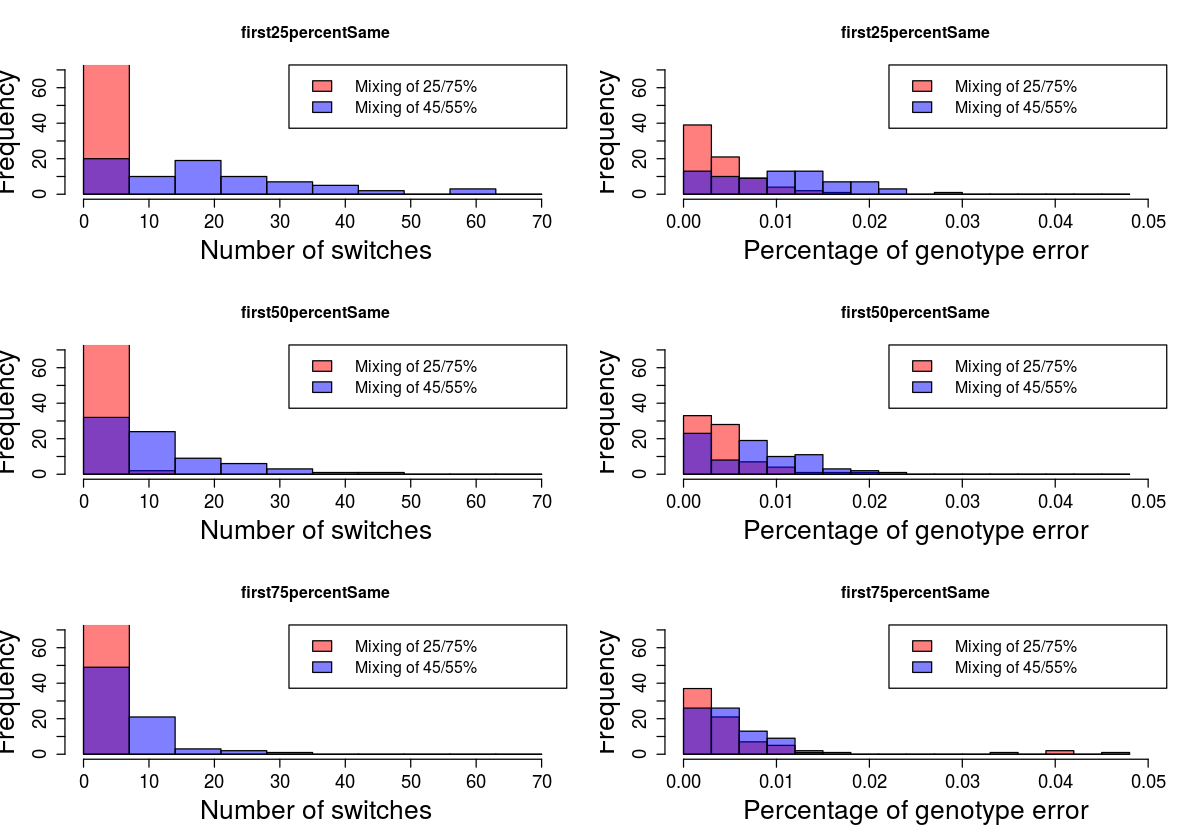

In [39]:
options(repr.plot.width=10, repr.plot.height=7)
plot_error_histogram(all.nonIBD.error) 


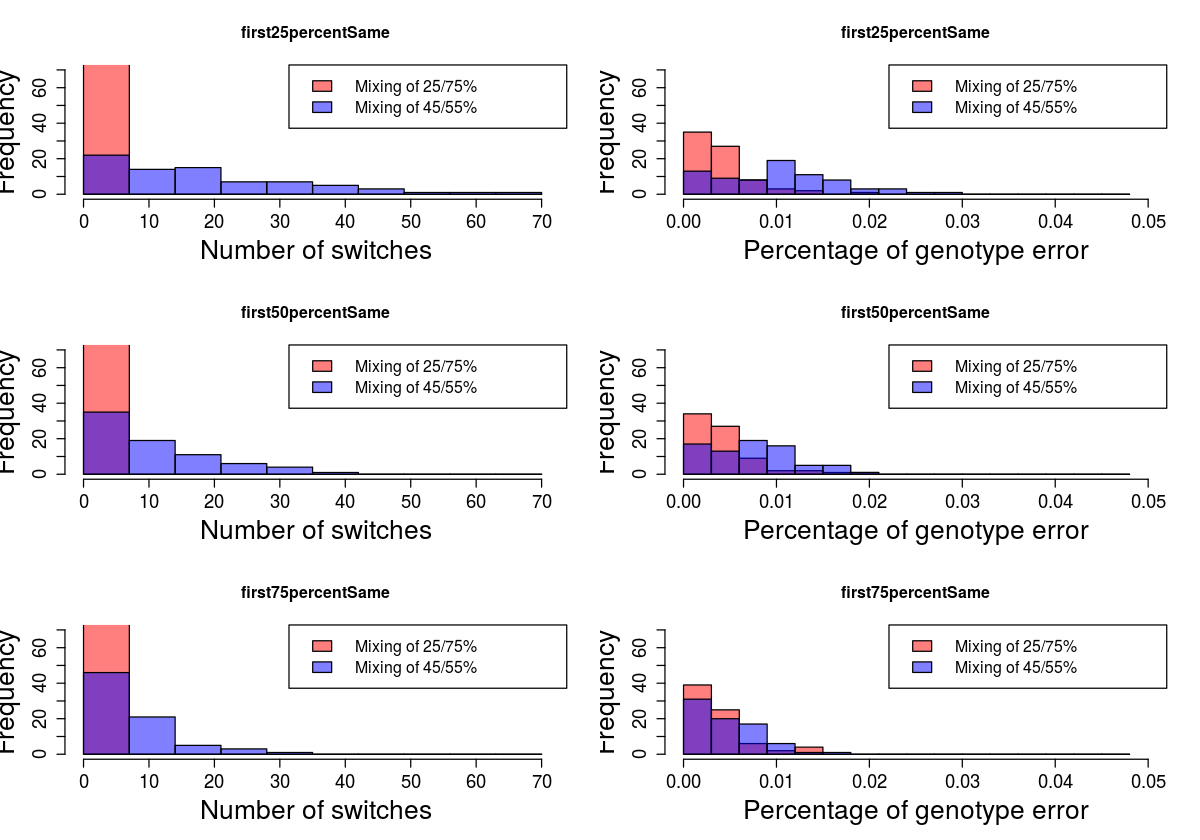

In [40]:
options(repr.plot.width=10, repr.plot.height=7)
plot_error_histogram(all.IBD.error) 

In [41]:
plot_error_ecdf <- function(){
par(mar = c(5,5,2,2))

plot(c(0,1), c(0,1), xlim = c(0,.05), ylim = c(0, 1), type=  "n", 
     xlab = "Genotype Error", ylab = "Cumulative frequencies", 
     cex.axis = tick_size, cex.lab = label_size)
x = seq(0, 0.05, length.out = 100)
col.ary = c("blue", "green", "red")
col.ct = 1
for (case in paste("first", c(25, 50, 75), "percentSame", sep ="")){
    for (panel in c("25v75")){
#    for (panel in c("25v75", "45v55")){
        tmp.case.panel = paste(case, ".", panel, sep ="")
        tmp.data.nonIBD = filter(all.nonIBD.error, case_panel == tmp.case.panel)
        ecdf.nonIBD = ecdf(tmp.data.nonIBD$genotypError)
        tmp.data.IBD = filter(all.IBD.error, case_panel == tmp.case.panel)
        ecdf.IBD = ecdf(tmp.data.IBD$genotypError)

        lines(x, ecdf.nonIBD(x), col = col.ary[col.ct], lty = 1, lwd = 2)
        lines(x, ecdf.IBD(x), col = col.ary[col.ct], lty = 2, lwd = 2)
    }
    col.ct = col.ct + 1
}
legend("right", legend = c("DEploidIBD", "DEploid"), lty = c(2, 1), 
       lwd = 2, bty = "n", cex = label_size)
legend("bottomright", pch = 16, legend = c("Low relatedness",
                                           "Moderate relatedness",
                                           "High relatedness"), 
       col = 4:2, text.col = par("fg"), cex = label_size, bty = "n")
}

## Cumulative error frequency

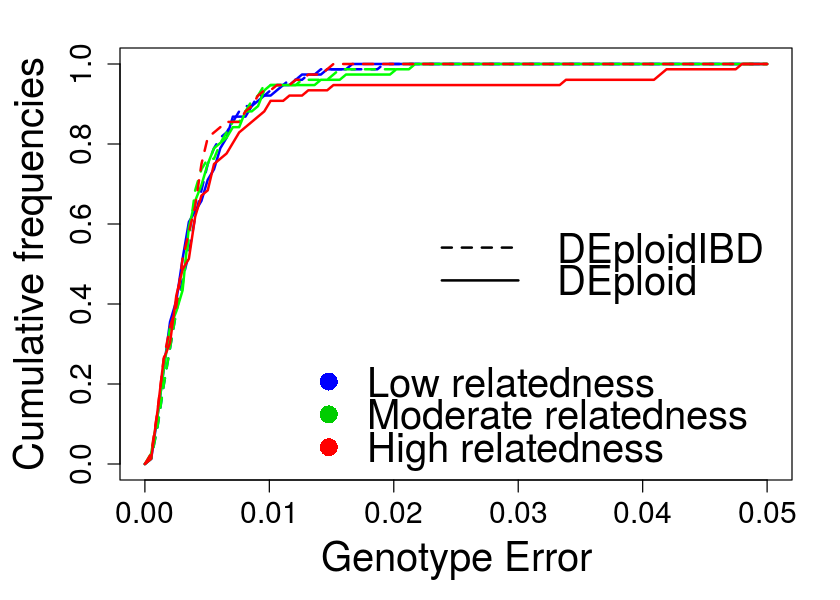

In [42]:
options(repr.plot.width=7, repr.plot.height=5)
plot_error_ecdf ()

# Results 
## The rate and structure of mixed infection in 2,344 P. falciparum field samples from 13 countries

After variant 178 calling and filtering, we genotyped approximately 1M variable SNP positions across all samples, sequenced to an average depth of 86 (range 12.6 – 192.5)

In [55]:
dim(pf3k_mixedIBD_meta)
summary(pf3k_mixedIBD_meta$Depth) %>% round
quantile(pf3k_mixedIBD_meta$Depth, .05)
quantile(pf3k_mixedIBD_meta$Depth, .95)
length(unique(pf3k_mixedIBD_meta$Population))


[1] 2344   17

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      5      41      74      86     116     676 

5% 
12.592

95% 
192.484

[1] 14

In [56]:
country_mixPercent = summarise(groupByCountry, percent_mix = sum(Est_K>1) / 
                               length(Est_K))
country_mixPercent

Population,percent_mix
Bangladesh,0.5400000
DR of the Congo,0.5486726
Ghana,0.5679443
Guinea,0.4639175
Laos,0.4166667
Malawi,0.6301887
Mali,0.5416667
Myanmar,0.2166667
North_Cambodia,0.3052209
Senegal,0.1824818


Between 5.1% (Senegal) and 40% (Malawi) of individuals have more than two strains present and, at
the population level, there is a positive correlation

In [58]:
print("% of mixture > 2 ")
country_complex_mix = summarise(groupByCountry, percent_mix = sum(Est_K>2) / 
                                length(Est_K))
country_complex_mix

[1] "% of mixture > 2 "


Population,percent_mix
Bangladesh,0.24000000
DR of the Congo,0.28318584
Ghana,0.28919861
Guinea,0.23711340
Laos,0.17857143
Malawi,0.39622642
Mali,0.22916667
Myanmar,0.06666667
North_Cambodia,0.16064257
Senegal,0.05109489


[1] "Dual infection Vs mixed infection"



	Pearson's product-moment correlation

data:  country_dual_mix$percent_mix and country_complex_mix$percent_mix
t = 3.9393, df = 12, p-value = 0.001965
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3663340 0.9164008
sample estimates:
      cor 
0.7509516 



Call:
lm(formula = country_complex_mix$percent_mix ~ country_dual_mix$percent_mix + 
    cont)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09035 -0.03423  0.01146  0.01935  0.16162 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)   
(Intercept)                   0.02211    0.07164   0.309  0.76339   
country_dual_mix$percent_mix  0.90827    0.28990   3.133  0.00953 **
contAsia                     -0.03495    0.03979  -0.878  0.39849   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06705 on 11 degrees of freedom
Multiple R-squared:  0.5925,	Adjusted R-squared:  0.5184 
F-statistic: 7.997 on 2 and 11 DF,  p-value: 0.007172


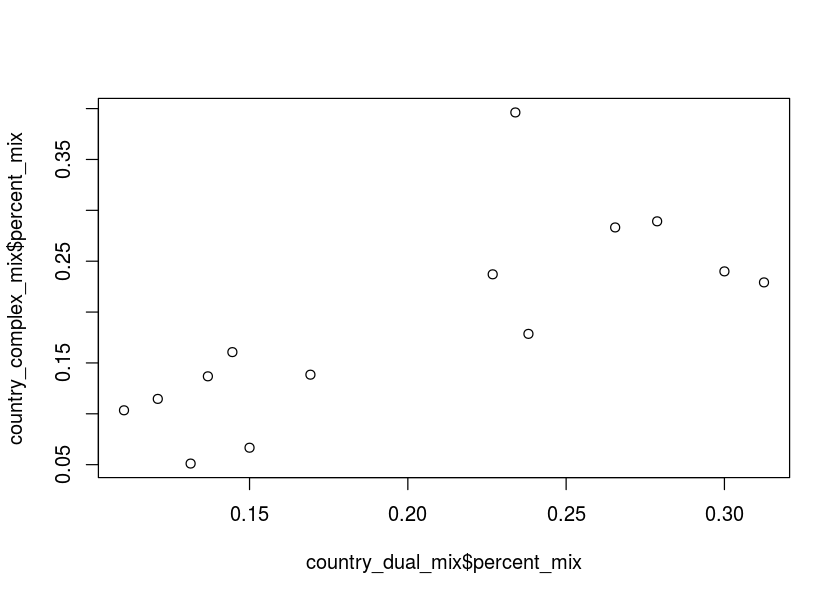

In [67]:
print("Dual infection Vs mixed infection")
country_dual_mix = summarise(groupByCountry, 
                             percent_mix = sum(Est_K==2)/length(Est_K))
cont = ifelse(country_dual_mix$Population %in% 
              c("Thailand", "North_Cambodia", "West_Cambodia", "Bangladesh", "Vietnam", 
                "Myanmar", "Laos"), "Asia", "Africa") %>% factor
nsam = summarise(groupByCountry, nsam = length(Est_K))
plot(country_dual_mix$percent_mix, country_complex_mix$percent_mix)
cor.test(country_dual_mix$percent_mix, country_complex_mix$percent_mix)
lm(country_complex_mix$percent_mix ~ country_dual_mix$percent_mix + cont) %>% summary

In [80]:
print("Relatedness")
print(summarise(groupByCountry, mean(relatedness, na.rm=T)) )
dual_infection = filter(pf3k_mixedIBD_meta, Est_K==2)
complex_infection = filter(pf3k_mixedIBD_meta, Est_K>2)

filter(dual_infection, Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                         "Bangladesh", "Vietnam", 
                                         "Myanmar", "Laos"))$relatedness %>%  
    mean(., na.rm=T) %>% cat("Asia dual infection relatedness", ., "\n")
filter(dual_infection, !Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                          "Bangladesh", "Vietnam", 
                                          "Myanmar", "Laos"))$relatedness %>%  
    mean(., na.rm=T) %>% cat("Africa dual infection relatedness", ., "\n")

filter(complex_infection, Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                            "Bangladesh", "Vietnam", 
                                            "Myanmar", "Laos"))$relatedness %>% 
    mean(., na.rm=T) %>% cat("Asia comples infection relatedness", ., "\n")
filter(complex_infection, !Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                             "Bangladesh", "Vietnam", 
                                             "Myanmar", "Laos"))$relatedness %>% 
    mean(., na.rm=T) %>% cat("Africa complex infection relatedness", ., "\n")


[1] "Relatedness"
# A tibble: 14 x 2
   Population      `mean(relatedness, na.rm = T)`
   <chr>                                    <dbl>
 1 Bangladesh                               0.495
 2 DR of the Congo                          0.357
 3 Ghana                                    0.263
 4 Guinea                                   0.210
 5 Laos                                     0.435
 6 Malawi                                   0.278
 7 Mali                                     0.360
 8 Myanmar                                  0.402
 9 North_Cambodia                           0.428
10 Senegal                                  0.393
11 Thailand                                 0.468
12 The Gambia                               0.527
13 Vietnam                                  0.459
14 West_Cambodia                            0.590
Asia dual infection relatedness 0.4756032 
Africa dual infection relatedness 0.2891736 
Asia comples infection relatedness 0.4977873 
Africa complex infection rela

In [83]:
country_dual_infection_relatedness = groupByCountry %>% 
    filter(., Est_K == 2) %>% summarise(., rho = mean(relatedness, na.rm=T))
country_dual_infection_relatedness
country_complex_infection_relatedness = groupByCountry %>% 
    filter(., Est_K>2) %>% summarise(., rho = mean(relatedness, na.rm=T))

cor.test(country_dual_infection_relatedness$rho, 
        country_complex_infection_relatedness$rho)
lm(country_dual_infection_relatedness$rho ~ 
   country_complex_infection_relatedness$rho) %>% summary

Population,rho
Bangladesh,0.4887820
DR of the Congo,0.3201329
Ghana,0.2540932
Guinea,0.2023944
Laos,0.4263297
Malawi,0.3086881
Mali,0.3706814
Myanmar,0.4587304
North_Cambodia,0.3620009
Senegal,0.2892980



	Pearson's product-moment correlation

data:  country_dual_infection_relatedness$rho and country_complex_infection_relatedness$rho
t = 2.0649, df = 12, p-value = 0.06124
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02547837  0.81986938
sample estimates:
      cor 
0.5120228 



Call:
lm(formula = country_dual_infection_relatedness$rho ~ country_complex_infection_relatedness$rho)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.220103 -0.064446  0.000403  0.046758  0.179571 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 0.1952     0.1016   1.922   0.0787
country_complex_infection_relatedness$rho   0.4762     0.2306   2.065   0.0612
                                           
(Intercept)                               .
country_complex_infection_relatedness$rho .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1067 on 12 degrees of freedom
Multiple R-squared:  0.2622,	Adjusted R-squared:  0.2007 
F-statistic: 4.264 on 1 and 12 DF,  p-value: 0.06124


In [ ]:
##################################checking upto here#

In [84]:
sum(pf3k_mixedIBD_meta$relatedness > .3, na.rm=T) / 
    sum(!is.na(pf3k_mixedIBD_meta$relatedness)) 



[1] 0.5327952

In [86]:
mix_frac = summarise(groupByCountry, frac = sum(Est_K>1)/length(Est_K))
relatedness = summarise(groupByCountry, rho = mean(relatedness, na.rm=T))
lm(relatedness$rho ~ mix_frac$frac + cont) %>% summary




Call:
lm(formula = relatedness$rho ~ mix_frac$frac + cont)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13109 -0.03795 -0.01760  0.03752  0.14835 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.45343    0.08275   5.479 0.000192 ***
mix_frac$frac -0.24251    0.16568  -1.464 0.171258    
contAsia       0.09097    0.05023   1.811 0.097476 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08189 on 11 degrees of freedom
Multiple R-squared:  0.4899,	Adjusted R-squared:  0.3972 
F-statistic: 5.283 on 2 and 11 DF,  p-value: 0.02466


In [63]:

idx = which(mix_frac$Population != "Senegal")
lm(relatedness$rho[idx] ~ mix_frac$frac[idx]) %>% summary



Call:
lm(formula = relatedness$rho[idx] ~ mix_frac$frac[idx])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.168222 -0.025693 -0.007327  0.035059  0.152172 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.59324    0.07206   8.233 4.97e-06 ***
mix_frac$frac[idx] -0.46385    0.16751  -2.769   0.0183 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08797 on 11 degrees of freedom
Multiple R-squared:  0.4107,	Adjusted R-squared:  0.3572 
F-statistic: 7.668 on 1 and 11 DF,  p-value: 0.01826


In [70]:
asia_dual_cluster = filter(dual_infection, Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                                             "Bangladesh", "Vietnam", 
                                                             "Myanmar", "Laos"))$cluster 
sum(asia_dual_cluster %in% c("Sib", "HighSib")) / length(asia_dual_cluster)

africa_dual_cluster = filter(dual_infection, !Population %in% c("Thailand", "North_Cambodia", "West_Cambodia", 
                                                                "Bangladesh", "Vietnam", 
                                                                "Myanmar", "Laos"))$cluster 
sum(africa_dual_cluster %in% c("Sib", "HighSib")) / length(africa_dual_cluster)



[1] 0.6054422

[1] 0.3723724

# Characteristics of mixed infection correlate with local pathogen prevalence

In [41]:
pfpr = read_tsv("pfpr_rate_inferred_loess.txt")
#pfpr = read_tsv("pfpr_rate_inferred.txt")

#range(pfpr$mean_pfpr, na.rm = T)

mean_eff_k = c()
mean_relatedness = c()

n.sample = c()

for ( i in 1:dim(pfpr)[1] ){

    country = pfpr$country[i]# label[i] %>% gsub(".2.*$","",.) %>% gsub(".1.*$","",.)
    if (country=="Gambia"){country ="The Gambia"}
    if (country=="Congo"){country ="DR of the Congo"}

    year = pfpr$year[i]
    tmpdata = pf3k_mixedIBD_meta[pf3k_mixedIBD_meta$Population == country & pf3k_mixedIBD_meta$year == year,]
    mean_eff_k = c(mean_eff_k,  mean(tmpdata$eff_k))
    mean_relatedness = c(mean_relatedness, mean(tmpdata$relatedness, na.rm = T))
    n.sample = c(n.sample, nrow(tmpdata))
}
country.list = pfpr$country #label %>% gsub(".2.*$","",.) %>% gsub(".1.*$","",.)
asia.idx.bool = country.list %in% c("Thailand", "Cambodia", "Bangladesh", "Vietnam", "Myanmar", "Laos")
africa.idx.bool = (!country.list %in% c("Thailand", "Cambodia", "Bangladesh", "Vietnam", "Myanmar", "Laos"))

pfpr = pfpr[n.sample>0,]
mean_eff_k = mean_eff_k[n.sample>0]
mean_relatedness = mean_relatedness[n.sample>0]
n.sample = n.sample[n.sample>0]




Parsed with column specification:
cols(
  country = col_character(),
  year = col_integer(),
  pfpr = col_double()
)


In [43]:
mean_relatedness

[1] 0.27321338 0.35717337 0.25153388 0.25961451 0.25008584 0.30984193
 [7] 0.30679018 0.35982140        NaN 0.62478416        NaN        NaN
[13] 0.03254611        NaN        NaN        NaN 0.47240604 0.36216941
[19] 0.39854262 0.52716355 0.22007233 0.34114405 0.57695801 0.08816371
[25] 0.38673346 0.56366122 0.49658704 0.48369621 0.43655315 0.57463129
[31] 0.37173969 0.67062365 0.25652622 0.45964265        NaN

In [44]:
#pfpr[which.max(pfpr$mean_pfpr),]
#pfpr[which.min(pfpr$mean_pfpr),]

pfpr %>% filter(., country %in% c("Thailand", "Cambodia", 
                                  "Bangladesh", "Vietnam", 
                                  "Myanmar", "Laos")) %>% 
    summarise(., mean(pfpr, na.rm = T))

pfpr %>% filter(., !country %in% c("Thailand", "Cambodia", 
                                   "Bangladesh", "Vietnam", 
                                   "Myanmar", "Laos")) %>% 
    summarise(., mean(pfpr, na.rm = T))

"mean(pfpr, na.rm = T)"
0.05986307


"mean(pfpr, na.rm = T)"
0.2161652


[1] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
  [6] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
 [11] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
 [16] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
 [21] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
 [26] "Malawi"     "Malawi"     "Malawi"     "Malawi"     "Malawi"    
 [31] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [36] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [41] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [46] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [51] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [56] "Congo"      "Congo"      "Congo"      "Congo"      "Congo"     
 [61] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [66] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [71] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [76] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [81] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [86] "Ghana"      "Ghana"      "Ghana"      "Ghana"      "Ghana"     
 [91] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
 [96] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
[101] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
[106] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
[111] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
[116] "Mali"       "Mali"       "Mali"       "Mali"       "Mali"      
[121] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[126] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[131] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[136] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[141] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[146] "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"    "Nigeria"   
[151] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[156] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[161] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[166] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[171] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[176] "Senegal"    "Senegal"    "Senegal"    "Senegal"    "Senegal"   
[181] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[186] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[191] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[196] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[201] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[206] "Gambia"     "Gambia"     "Gambia"     "Gambia"     "Gambia"    
[211] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[216] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[221] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[226] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[231] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[236] "Guinea"     "Guinea"     "Guinea"     "Guinea"     "Guinea"    
[241] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[246] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[251] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[256] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[261] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[266] "Thailand"   "Thailand"   "Thailand"   "Thailand"   "Thailand"  
[271] "Cambodia"   "Cambodia"   "Cambodia"   "Cambodia"   "Cambodia"  
[276] "Cambodia"   "Cambodia"   "Cambodia"   "Cambodia"   "Cambodia"  
[281] "Cambodia"   "Cambod

In [46]:
cont = ifelse(pfpr$country %in% c("Thailand", "Cambodia", 
                                  "Bangladesh", "Vietnam", 
                                  "Myanmar", "Laos"), 
              "Asia", "Africa") %>% as.factor


In [47]:
lm(pfpr$pfpr ~ mean_eff_k + cont, weights = n.sample) %>% summary
lm(pfpr$pfpr ~ mean_relatedness + cont, weights = n.sample) %>% summary



Call:
lm(formula = pfpr$pfpr ~ mean_eff_k + cont, weights = n.sample)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.61705 -0.16437  0.03719  0.18206  1.43748 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.27834    0.07959  -3.497  0.00149 ** 
mean_eff_k   0.36778    0.05138   7.158 5.80e-08 ***
contAsia    -0.13104    0.02196  -5.968 1.53e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3691 on 30 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.9044,	Adjusted R-squared:  0.898 
F-statistic: 141.9 on 2 and 30 DF,  p-value: 5.082e-16



Call:
lm(formula = pfpr$pfpr ~ mean_relatedness + cont, weights = n.sample)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-1.1550 -0.3287 -0.1524  0.2468  0.9568 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.42436    0.04691   9.047 4.88e-09 ***
mean_relatedness -0.43877    0.14743  -2.976 0.006760 ** 
contAsia         -0.16091    0.03689  -4.362 0.000229 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5543 on 23 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.833,	Adjusted R-squared:  0.8185 
F-statistic: 57.38 on 2 and 23 DF,  p-value: 1.148e-09


In [48]:
lm(pfpr$pfpr ~ mean_eff_k + mean_relatedness + cont, 
   weights = n.sample) %>% summary 

# Validated with weighted mean of pfpr, no change in the result
#lm(pfpr$wt_mean_pfpr ~ mean_eff_k + cont, weights = n.sample) %>% summary
#lm(pfpr$wt_mean_pfpr ~ mean_eff_k + mean_relatedness + cont, 
#weights = n.sample) %>% summary 


Call:
lm(formula = pfpr$pfpr ~ mean_eff_k + mean_relatedness + cont, 
    weights = n.sample)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.61306 -0.22973 -0.08013  0.14639  1.20203 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.14210    0.12052  -1.179  0.25094    
mean_eff_k        0.32356    0.06617   4.890 6.89e-05 ***
mean_relatedness -0.22466    0.11317  -1.985  0.05974 .  
contAsia         -0.10158    0.02879  -3.528  0.00189 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3924 on 22 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:   0.92,	Adjusted R-squared:  0.9091 
F-statistic: 84.32 on 3 and 22 DF,  p-value: 3.203e-12


In [49]:
lm(pfpr$pfpr[cont=="Africa"] ~ mean_eff_k[cont=="Africa"], 
   weights = n.sample[cont=="Africa"]) %>% summary

lm(pfpr$pfpr[cont=="Africa"] ~ mean_relatedness[cont=="Africa"], 
   weights = n.sample[cont=="Africa"]) %>% summary

lm(pfpr$pfpr[cont=="Africa"] ~ mean_eff_k[cont=="Africa"] + mean_relatedness[cont=="Africa"], 
   weights = n.sample[cont=="Africa"]) %>% summary
#lm(pfpr$mean_pfpr[cont=="Africa"] ~ mean_eff_k[cont=="Africa"] + 
#mean_relatedness[cont=="Africa"]) %>% summary 

# Validated with weighted mean of pfpr, no change in the result
#lm(pfpr$wt_mean_pfpr[cont=="Africa"] ~ mean_eff_k[cont=="Africa"], 
#weights = n.sample[cont=="Africa"]) %>% summary



Call:
lm(formula = pfpr$pfpr[cont == "Africa"] ~ mean_eff_k[cont == 
    "Africa"], weights = n.sample[cont == "Africa"])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.61706 -0.18364 -0.01305  0.10539  1.43748 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -0.27833    0.09325  -2.985  0.00761 ** 
mean_eff_k[cont == "Africa"]  0.36777    0.06023   6.106 7.18e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4194 on 19 degrees of freedom
Multiple R-squared:  0.6624,	Adjusted R-squared:  0.6447 
F-statistic: 37.28 on 1 and 19 DF,  p-value: 7.175e-06



Call:
lm(formula = pfpr$pfpr[cont == "Africa"] ~ mean_relatedness[cont == 
    "Africa"], weights = n.sample[cont == "Africa"])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.00837 -0.52480  0.06785  0.33744  0.61355 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.50616    0.06379   7.935 2.45e-06 ***
mean_relatedness[cont == "Africa"] -0.70906    0.20462  -3.465  0.00418 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5873 on 13 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.4802,	Adjusted R-squared:  0.4402 
F-statistic: 12.01 on 1 and 13 DF,  p-value: 0.004183



Call:
lm(formula = pfpr$pfpr[cont == "Africa"] ~ mean_eff_k[cont == 
    "Africa"] + mean_relatedness[cont == "Africa"], weights = n.sample[cont == 
    "Africa"])

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-0.6345 -0.2705 -0.1376  0.2547  1.0199 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)                        -0.02385    0.17452  -0.137  0.89354   
mean_eff_k[cont == "Africa"]        0.27719    0.08760   3.164  0.00815 **
mean_relatedness[cont == "Africa"] -0.37787    0.18889  -2.000  0.06860 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4514 on 12 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.7166,	Adjusted R-squared:  0.6694 
F-statistic: 15.17 on 2 and 12 DF,  p-value: 0.0005177


In [55]:
wtd.cor(pfpr$pfpr[cont=="Africa"], mean_eff_k[cont=="Africa"], weight = n.sample[cont == "Africa"] )
wtd.cor(pfpr$pfpr[cont=="Africa"], mean_relatedness[cont=="Africa"], weight = n.sample[cont == "Africa"])
wtd.cor(pfpr$pfpr[cont=="Asia"], mean_eff_k[cont=="Asia"], weight = n.sample[cont == "Asia"] )
wtd.cor(pfpr$pfpr[cont=="Asia"], mean_relatedness[cont=="Asia"], weight = n.sample[cont == "Asia"])

,correlation,std.err,t.value,p.value
Y,0.8138921,0.1332942,6.105983,7.17533e-06


,correlation,std.err,t.value,p.value
Y,-0.6929449,0.1999668,-3.465299,0.004183454


,correlation,std.err,t.value,p.value
Y,0.6003158,0.2529073,2.37366,0.03903263


,correlation,std.err,t.value,p.value
Y,-0.1377637,0.330155,-0.4172696,0.6862588


In [51]:
lm(pfpr$pfpr[cont=="Asia"] ~ mean_eff_k[cont=="Asia"], 
   weights = n.sample[cont=="Asia"]) %>% summary
lm(pfpr$pfpr[cont=="Asia"] ~ mean_relatedness[cont=="Asia"], 
 weights = n.sample[cont=="Asia"]) %>% summary
lm(pfpr$pfpr[cont=="Asia"] ~ mean_eff_k[cont=="Asia"]+mean_relatedness[cont=="Asia"], 
 weights = n.sample[cont=="Asia"]) %>% summary
#lm(pfpr$mean_pfpr[cont=="Asia"] ~ mean_eff_k[cont=="Asia"] + 
#mean_relatedness[cont=="Asia"]) %>% summary 

# Validated with weighted mean of pfpr, no change in the result
#lm(pfpr$wt_mean_pfpr[cont=="Asia"] ~ mean_eff_k[cont=="Asia"], 
#weights = n.sample[cont=="Asia"]) %>% summary



Call:
lm(formula = pfpr$pfpr[cont == "Asia"] ~ mean_eff_k[cont == "Asia"], 
    weights = n.sample[cont == "Asia"])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.30683 -0.09100  0.06594  0.22251  0.45714 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)  
(Intercept)                 -0.4095     0.1924  -2.128   0.0592 .
mean_eff_k[cont == "Asia"]   0.3678     0.1550   2.374   0.0390 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2727 on 10 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.3604,	Adjusted R-squared:  0.2964 
F-statistic: 5.634 on 1 and 10 DF,  p-value: 0.03903



Call:
lm(formula = pfpr$pfpr[cont == "Asia"] ~ mean_relatedness[cont == 
    "Asia"], weights = n.sample[cont == "Asia"])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.23832 -0.12143 -0.04586 -0.01271  0.78745 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)
(Intercept)                       0.07697    0.07340   1.049    0.322
mean_relatedness[cont == "Asia"] -0.06116    0.14658  -0.417    0.686

Residual standard error: 0.356 on 9 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.01898,	Adjusted R-squared:  -0.09002 
F-statistic: 0.1741 on 1 and 9 DF,  p-value: 0.6863



Call:
lm(formula = pfpr$pfpr[cont == "Asia"] ~ mean_eff_k[cont == "Asia"] + 
    mean_relatedness[cont == "Asia"], weights = n.sample[cont == 
    "Asia"])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-0.30429 -0.11135 -0.00574  0.23921  0.51129 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)  
(Intercept)                      -0.39164    0.21119  -1.854   0.1008  
mean_eff_k[cont == "Asia"]        0.39064    0.16874   2.315   0.0493 *
mean_relatedness[cont == "Asia"] -0.09358    0.12112  -0.773   0.4620  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2922 on 8 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.4125,	Adjusted R-squared:  0.2657 
F-statistic: 2.809 on 2 and 8 DF,  p-value: 0.1191


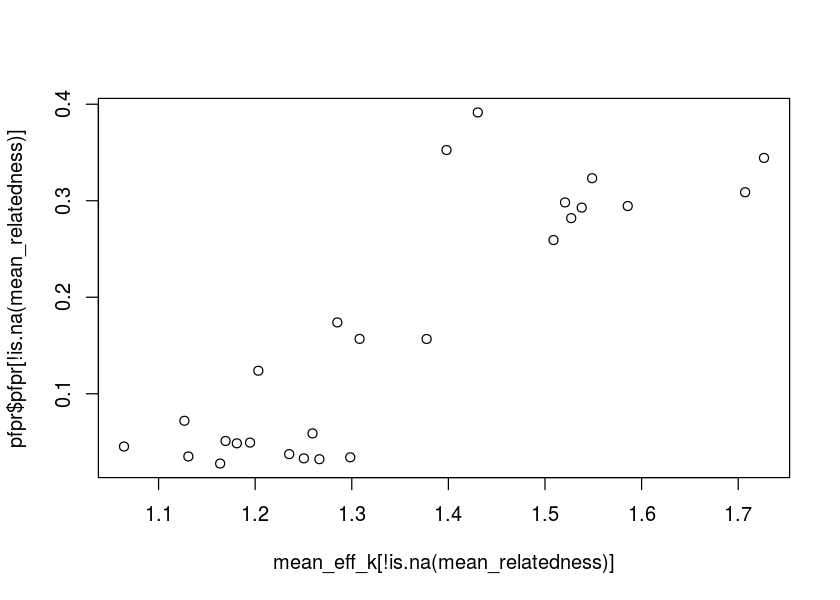

In [54]:
plot(mean_eff_k[!is.na(mean_relatedness)], pfpr$pfpr[!is.na(mean_relatedness)])